In [1]:
from params import input_params, time_params
from random_dna_chem import RandomDNAStrandDisplacementCircuit
from perturb_chem import RandomDNAChemPerturbationGillespy2
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np


import torch
from torch import nn
from torch.nn import functional
import torch.optim as optim

In [2]:
class ReadOutLayer(nn.Module):
    '''
        Readout layer of Random DNA Strand Displacement Circuit Reservoir Computer
        Single Perceptron that takes concentrations of species inside the reservoir as inputs
        Tasks: Hamming distance learning, Long-term memory task, Short-term memory task
    '''

    def __init__(self, numIn):
        super(ReadOutLayer, self).__init__()
        self.output = nn.Linear(in_features=numIn, out_features=1, bias=True)

    def forward(self, x):
        return self.output(x)

In [3]:
# Train the readout layer
def train_readout(readout, results, epochs, device):

    # Define criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(readout.parameters(), lr=0.001)

    # Initialize a list of losses and a running loss
    losses = []
    running_loss = 0

    x_matrix = [] # matrix of all concentration vectors
    for concentration in results.values():
        x_matrix.append(concentration)

    # Go through each epoch
    for epoch in range(epochs):
        losses_per_epoch = []
        # Go through each timestep
        for i in range(len(results['U0'])):
            # Build the input and target
            target = [results['U0'][i]] # target vector is concentration of U0 species
            x_matrix_i = [] # vector of the ith element of each species concentration in matrix
            for species_index in range(len(concentration_lookup)):
                x_matrix_i.append(x_matrix[species_index][i]) 
            x = torch.Tensor(x_matrix_i)
            y = torch.Tensor(target)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Make a forward pass, calculate loss, and backpropogate
            output = readout(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            # Stats
            losses_per_epoch.append(loss.item())
            running_loss += loss.item()
            if i % 1000 == 0: # calculate cumulative loss over 1000 timestep
                print("\tepoch {}, inst {:<4}\trunning loss: {}".format(epoch, i, running_loss))
                running_loss = 0
        losses.append(losses_per_epoch)
    # Return list of losses, containing list of losses per epoch
    return losses


In [4]:
# Test the readout layer
def test_readout(readout, results, device):

    # Initialize tracking variables
    total = 0
    correct = 0

    x_matrix = [] # matrix of all concentration vectors
    for concentration in results.values():
        x_matrix.append(concentration)

    # Go through each timestep
    for i in range(len(results['U0'])):
        # Build the input and target
        target = [results['U0'][i]] # target vector is concentration of U0 species
        x_matrix_i = [] # vector of the ith element of each species concentration in matrix
        for species_index in range(len(concentration_lookup)):
            x_matrix_i.append(x_matrix[species_index][i]) 
        x = torch.Tensor(x_matrix_i)
        y = torch.Tensor(target)

        # Make a forward pass, check for accuracy
        output = readout(x)
        total += 1
        if abs(output.item() - y.item()) < 0.01:
            correct += 1

        # Stats
        if i % 1000 == 0: # calculate cumulative accuracy over the entire simulation time up to each 1000 timestep
            print("\tinst {:<4}\tcurrent accuracy: {:.3f}%".format(i, (correct / total) * 100))

    # Print final result
    print("\tFinal accuracy: {:.3f}%".format((correct / total) * 100))


2020-03-24 16:00:00,653 - root - WARNING -  Unable to use Cython optimized SSA: No module named 'pyximport'. The performance of this package can be significantly increased if you install Cython.



Generating data...


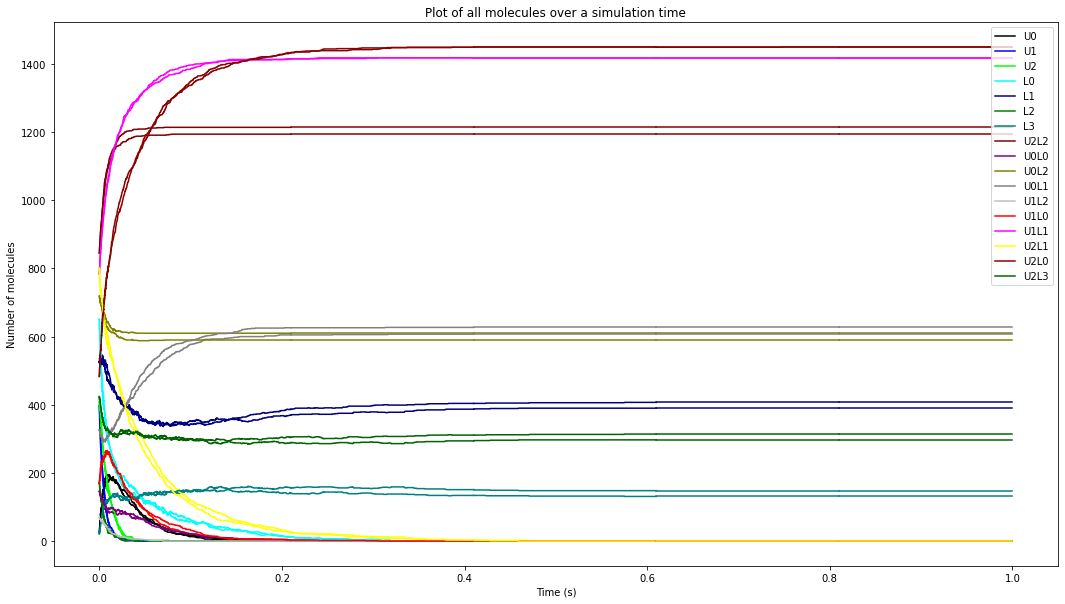

In [5]:
# Load data
print("\nGenerating data...")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

randomDNAChem = RandomDNAStrandDisplacementCircuit(input_params=input_params, 
                                                   time_params=time_params)
numIn = randomDNAChem.species_lookup['nS']

color_array = ['#000000', '#0000FF', '#00FF00', '#00FFFF', '#000080',
               '#008000', '#008080', '#800000', '#800080', '#808000',
               '#808080', '#C0C0C0', '#FF0000', '#FF00FF', '#FFFF00',
               '#8B0000', '#006400', '#BDB76B', '#008B8B', '#191970']

plt.figure(figsize = (18,10))
plt.title('Plot of all molecules over a simulation time')
plt.xlabel('Time (s)')
plt.ylabel('Number of molecules')

gillespy2_results = []
num_trajectories = 2

# Creating the Gillespy2 chemistry model in the non-perturb period
gillespy2_model = RandomDNAChemPerturbationGillespy2(non_gillespy2_chem=randomDNAChem,
                                                     rate_in_timeIndex=0, # index 0 for time t=0
                                                     period_start=randomDNAChem.time_params['time_array'][0],
                                                     period_end=randomDNAChem.time_params['time_array'][1],
                                                     previous_gillespy2_result=None)

# Result of stochastic Gillespie simulation for non-perturbation period
gillespy2_result = gillespy2_model.run(number_of_trajectories=num_trajectories)

# Result of stochastic Gillespie simulation for entire simulation time
gillespy2_results.append(gillespy2_result)

# Plot non-perturb period
for index in range(num_trajectories):
    trajectory = gillespy2_result[index]
    for species_index, species in enumerate(randomDNAChem.species_lookup['S']):
        species_plot = plt.plot(trajectory['time'],
                                trajectory['{}'.format(species)],
                                color=color_array[species_index],
                                label=species)

# Creating the Gillespy2 chemistry models in the perturb period
for time_index in range(1, len(randomDNAChem.time_params['time_array']) - 1):
    # Calculate the Gillespy2 time offset
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)

    trajectories = []
    for index in range(num_trajectories):
        previous_trajectory = gillespy2_result[index] # take the gillespy2_result from the previous period

        # Creating one Gillespy2 chemistry model in one trajectory in one perturb period
        gillespy2_model = RandomDNAChemPerturbationGillespy2(non_gillespy2_chem=randomDNAChem,
                                                             rate_in_timeIndex=time_index, # index 1 for time t=1 and so on
                                                             period_start=randomDNAChem.time_params['time_array'][time_index] - time_offset,
                                                             period_end=randomDNAChem.time_params['time_array'][time_index + 1] - time_offset,
                                                             previous_gillespy2_result=previous_trajectory)
        trajectory = gillespy2_model.run(number_of_trajectories=1) # run the single trajectory
        trajectories.append(trajectory)
    gillespy2_result = trajectories # gillespy2_result of the current period

    # Result of stochastic Gillespie simulation for entire simulation time
    gillespy2_results.append(gillespy2_result)

    # Plot each of the perturb period
    for index in range(num_trajectories):
        trajectory = gillespy2_result[index]
        for species_index, species in enumerate(randomDNAChem.species_lookup['S']):
            species_plot = plt.plot(trajectory['time'] + time_offset,
                                    trajectory['{}'.format(species)],
                                    color=color_array[species_index],
                                    label=species)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
# plot_name = 'random_dna_chem_with_perturb_junk'
try:
    plot_name
except NameError:
    plt.show()
else:
    plt.savefig('plots/' + plot_name + '.eps')


Training model: 
	epoch 0, inst 0   	running loss: 7018.40673828125
	epoch 0, inst 1000	running loss: nan
	epoch 0, inst 2000	running loss: nan
	epoch 0, inst 3000	running loss: nan
	epoch 0, inst 4000	running loss: nan
	epoch 0, inst 5000	running loss: nan
	epoch 0, inst 6000	running loss: nan
	epoch 1, inst 0   	running loss: nan
	epoch 1, inst 1000	running loss: nan
	epoch 1, inst 2000	running loss: nan
	epoch 1, inst 3000	running loss: nan
	epoch 1, inst 4000	running loss: nan
	epoch 1, inst 5000	running loss: nan
	epoch 1, inst 6000	running loss: nan
	epoch 2, inst 0   	running loss: nan
	epoch 2, inst 1000	running loss: nan
	epoch 2, inst 2000	running loss: nan
	epoch 2, inst 3000	running loss: nan
	epoch 2, inst 4000	running loss: nan
	epoch 2, inst 5000	running loss: nan
	epoch 2, inst 6000	running loss: nan
	epoch 3, inst 0   	running loss: nan
	epoch 3, inst 1000	running loss: nan
	epoch 3, inst 2000	running loss: nan
	epoch 3, inst 3000	running loss: nan
	epoch 3, inst 4000	

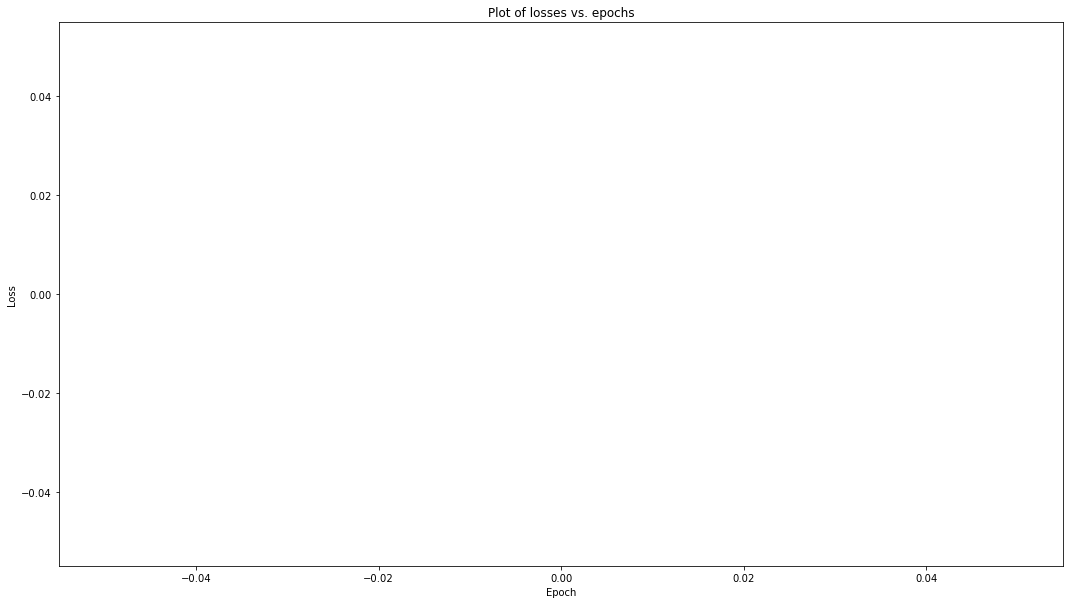

In [8]:
# Create trainset: Concentration from reservoir = readout inputs (use trajectory 0 for trainset)
trajectory_in_use = 0
time_lookup = list(gillespy2_results[0][trajectory_in_use]['time']) # time vector at non-perturbed period
for time_index in range(1, len(randomDNAChem.time_params['time_array']) - 1): # time vector at perturbed period
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)
    time_lookup += list(gillespy2_results[time_index][trajectory_in_use]['time'] + time_offset)

concentration_lookup = {}
for species_name in randomDNAChem.species_lookup['S']:
    concentrations = []
    for time_index in range(randomDNAChem.time_params['num_perturb'] + 1): # number of periods 
        concentrations += list(gillespy2_results[time_index][trajectory_in_use][species_name])
    concentration_lookup.update({'{}'.format(species_name): concentrations})

trainset = concentration_lookup.copy() # trainset is a scaled concentration lookup
for species_name, concentration in concentration_lookup.items():
    scale_factor = max(concentration) / 1 # scale the concentration value between 0 and 1
    for i in range(len(concentration)):
        trainset[species_name][i] = concentration[i] / scale_factor

# Training
print('Training model: ')
readout = ReadOutLayer(numIn=numIn)
num_epoch = 5
losses = train_readout(readout=readout, results=trainset, epochs=num_epoch, device=device)
avg_losses_per_epoch = []
for i in range(num_epoch): # list index 0 (epoch 1) to list index 4 (epoch 5)
    avg_losses_per_epoch.append(np.mean(losses[i]))

plt.figure(figsize = (18,10))
plt.title('Plot of losses vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, num_epoch+1), avg_losses_per_epoch)
plt.savefig('losses_vs_epochs' + '.eps')


In [7]:
# Create testset: Concentration from reservoir = readout inputs (use trajectory 1 for testset)
trajectory_in_use = 1
time_lookup = list(gillespy2_results[0][trajectory_in_use]['time']) # time vector at non-perturbed period
for time_index in range(1, len(randomDNAChem.time_params['time_array']) - 1): # time vector at perturbed period
    time_offset = randomDNAChem.time_params['t_perturb'] + randomDNAChem.time_params['t_hold'] * (time_index - 1)
    time_lookup += list(gillespy2_results[time_index][trajectory_in_use]['time'] + time_offset)

concentration_lookup = {}
for species_name in randomDNAChem.species_lookup['S']:
    concentrations = []
    for time_index in range(randomDNAChem.time_params['num_perturb'] + 1): # number of periods 
        concentrations += list(gillespy2_results[time_index][trajectory_in_use][species_name])
    concentration_lookup.update({'{}'.format(species_name): concentrations})

testset = concentration_lookup.copy() # testset is a scaled concentration lookup
for species_name, concentration in concentration_lookup.items():
    scale_factor = max(concentration) / 1 # scale the concentration value between 0 and 1
    for i in range(len(concentration)):
        testset[species_name][i] = concentration[i] / scale_factor

# Testing
print('Testing model: ')
test_readout(readout=readout, results=testset, device=device)


Testing model: 
	inst 0   	current accuracy: 0.000%
	inst 1000	current accuracy: 0.000%
	inst 2000	current accuracy: 0.000%
	inst 3000	current accuracy: 0.000%
	inst 4000	current accuracy: 0.000%
	inst 5000	current accuracy: 0.000%
	inst 6000	current accuracy: 0.000%
	Final accuracy: 0.000%
